# Visualization of K-Means applied on features

In [20]:
import cv2 as cv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
import src
from src.data_generation.utils import downsample_img, normalize_img
from src.hierarchical_properties.clustering import k_means_on_feature, \
    ward_on_feature
import importlib

importlib.reload(src.hierarchical_properties.clustering)
from src.hierarchical_properties.clustering import k_means_on_feature, \
    ward_on_feature

In [22]:
# Load data
example_dog_file_path = '../../data/dog002.npz'

loaded = np.load(example_dog_file_path)
img = loaded['image']
img = np.moveaxis(img, 0, -1)
b1 = loaded['b1']
b2 = loaded['b2']
b3 = loaded['b3']
b4 = loaded['b4']

patches = [b1, b2, b3, b4]

In [23]:
# Constants
type_net = 'simclrv2'
type_net_2 = 'v2'

results_folder_rel_path = "../../results/"

full_size = 448
patch_sizes = [b1.shape[0], b2.shape[0],
               b3.shape[0], b4.shape[0]]
channel_idx = 2
n_channels_patches = [b1.shape[channel_idx], b2.shape[channel_idx],
                      b3.shape[channel_idx], b4.shape[channel_idx]]

# K-Means
k_s = [2, 4, 6, 8]
max_iter = 300
epsilon = 0.0001
attempts = 10
normalize = True
bilinear_interpolation_flag = cv.INTER_LINEAR
nn_interpolation_flag = cv.INTER_NEAREST

weight_original_img = 0.4
weight_colored_patch = 0.4
gamma = 0

In [24]:
img = downsample_img(img, full_size, full_size, False)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = normalize_img(img, min_value=0, max_value=255, return_int_values=True)

In [25]:
final_images_bilinear_interp = []
final_images_nn_interp = []
# Sum of squared distance from each point to their corresponding centers.
# Each element corresponds to a different number of clusters.
compactness_k_dict = {}

j = 0
for patch in patches:
    # Initialize dict that will contain compactness values for each k for
    # each patch
    compactness_k_dict[j] = []
    for k in k_s:
        seg_patch, compactness = k_means_on_feature(
            patch, n_clusters=k, max_iter=max_iter, epsilon=epsilon,
            attempts=attempts, normalize=normalize,
            n_channels=n_channels_patches[j], plot=False)
        compactness_k_dict[j].append(compactness)
        seg_full = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=bilinear_interpolation_flag)

        # Convert the original image as grayscale image to put it in the
        # background to be able to put the patch (the output of Kmeans)
        # over it in a transparent way.
        # Single channel grayscale image
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Repeat the grayscale image along all the 3 channels
        stacked_img = np.stack((img_gray,) * 3, axis=-1)

        final_img_bilinear_interp = cv.addWeighted(
            stacked_img, weight_original_img, seg_full, weight_colored_patch,
            gamma)
        final_images_bilinear_interp.append(final_img_bilinear_interp)

        seg_full_nearest_neighbor_interp = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=nn_interpolation_flag)

        nearest_neighbor_interp_final_img = cv.addWeighted(
            stacked_img, weight_original_img,
            seg_full_nearest_neighbor_interp,
            weight_colored_patch, gamma)
        final_images_nn_interp.append(nearest_neighbor_interp_final_img)
    j += 1

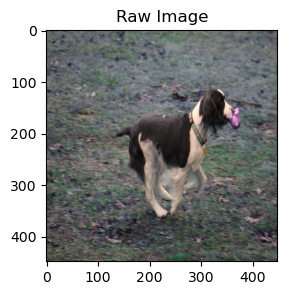

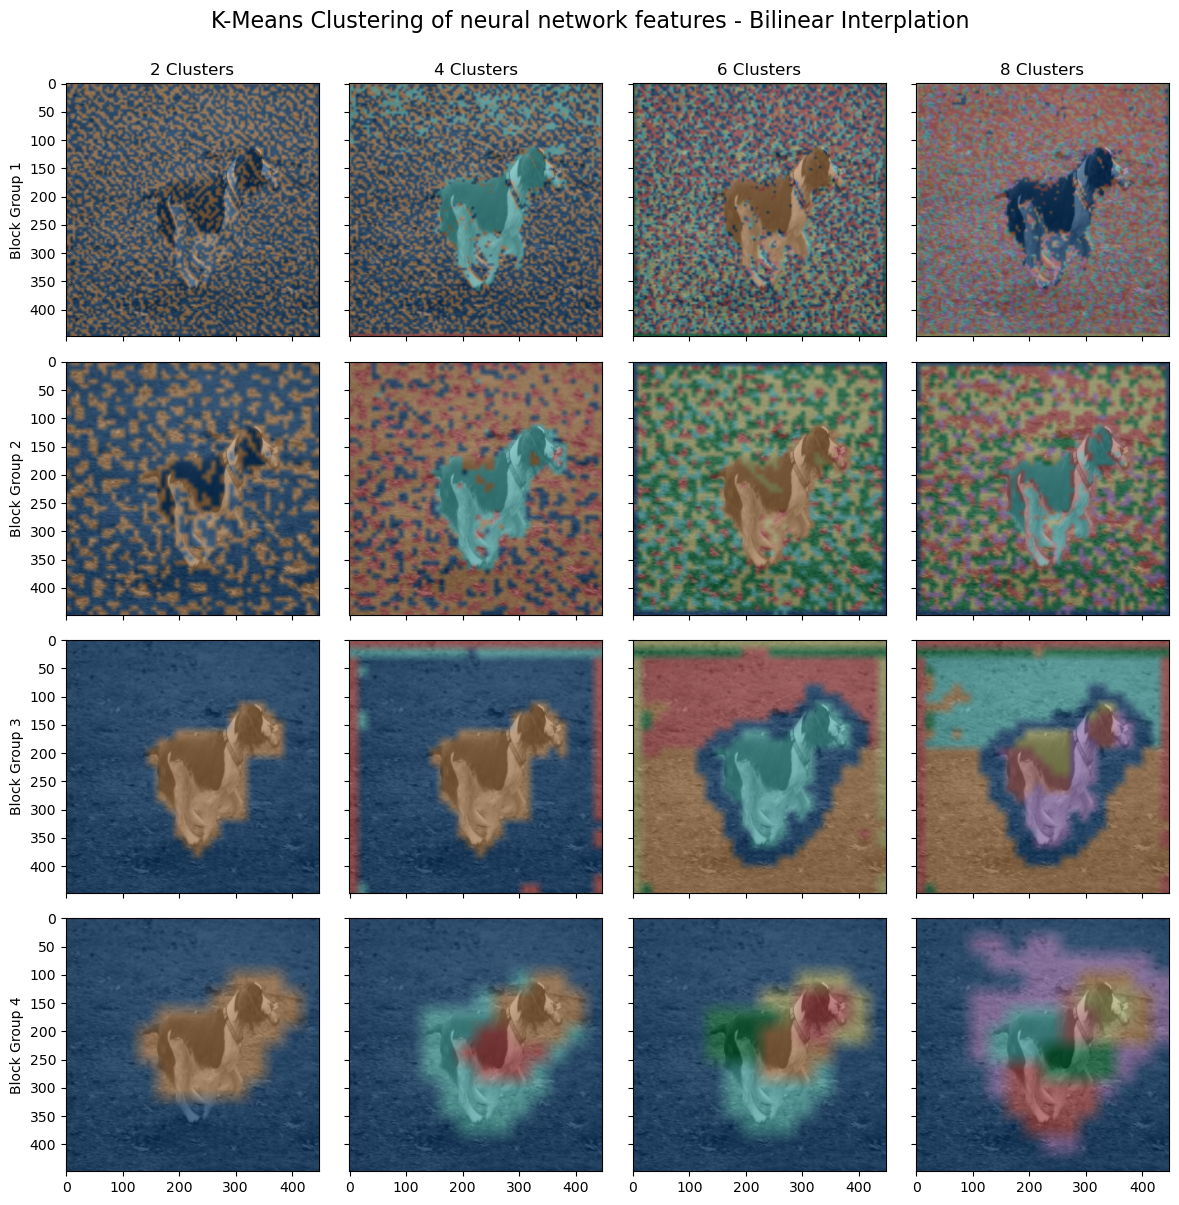

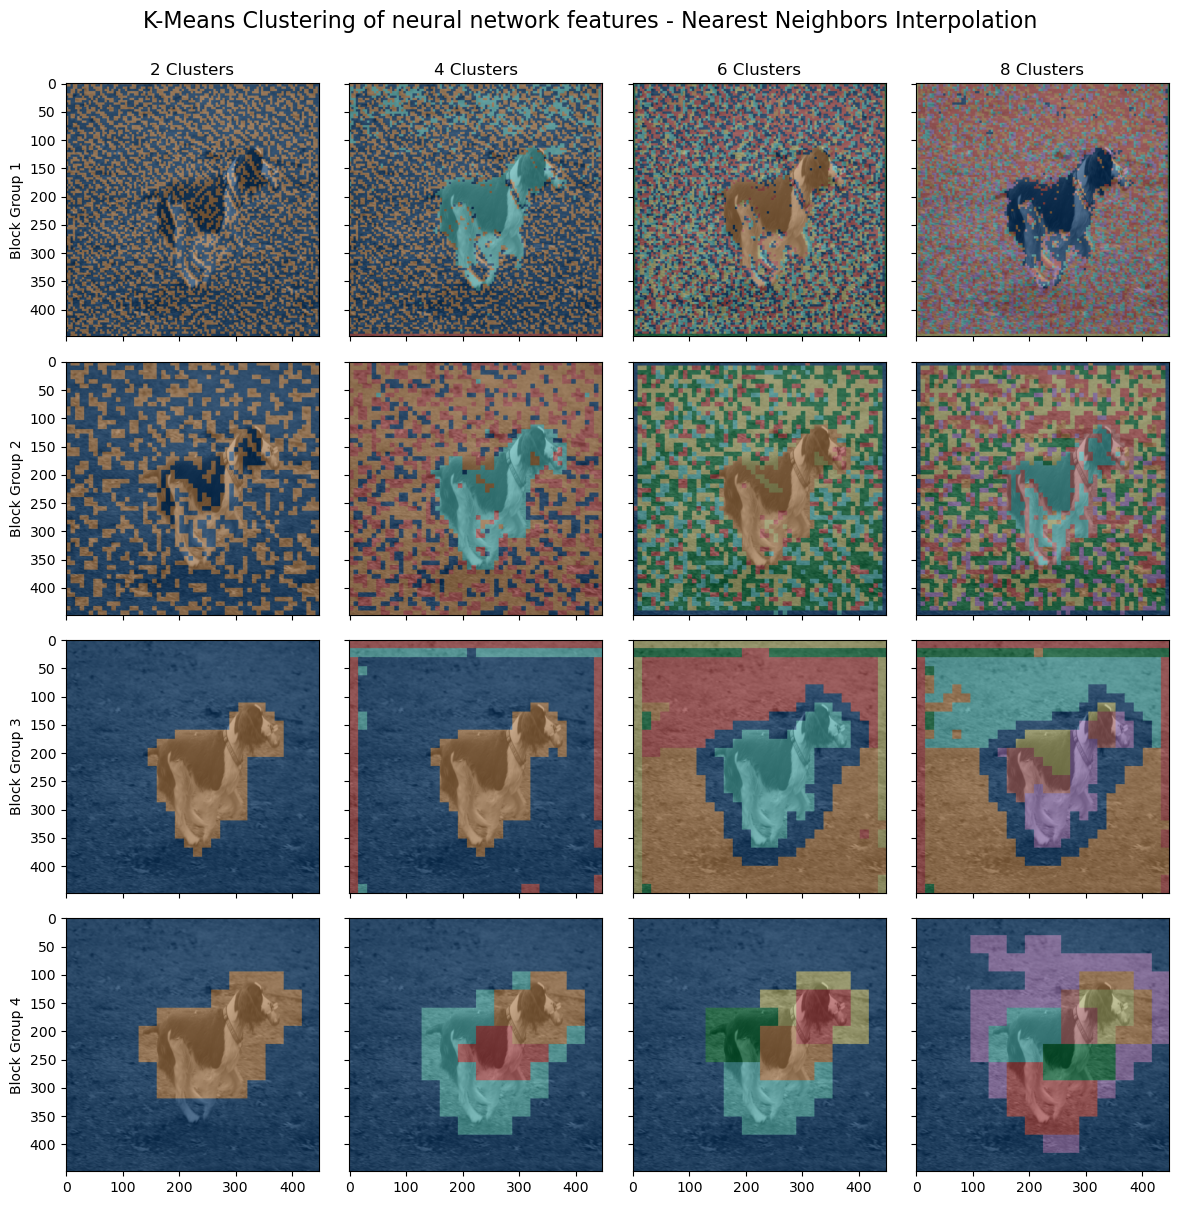

In [26]:
# Plots

# Raw Image
fig = plt.figure(figsize=(3, 3))
plt.title("Raw Image")
plt.imshow(img)
plt.show()

# Bilinear Interplation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s), figsize=(12, 12),
                        sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_kmeans, ax in zip(final_images_bilinear_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_kmeans)
    i += 1
fig.suptitle(
    "K-Means Clustering of neural network features "
    + "- Bilinear Interplation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(results_folder_rel_path + "exp1_" + type_net + "_kmeans_bi.pdf", dpi=100)
plt.show()

# Nearest Neighbors Interpolation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                        figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_kmeans, ax in zip(final_images_nn_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_kmeans)
    i += 1
fig.suptitle(
    "K-Means Clustering of neural network features "
    + "- Nearest Neighbors Interpolation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(results_folder_rel_path + "exp1_" + type_net + "_kmeans_nni.pdf",
            dpi=100)
plt.show()

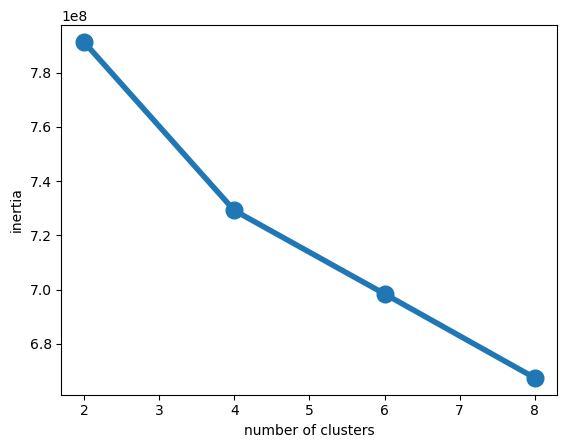

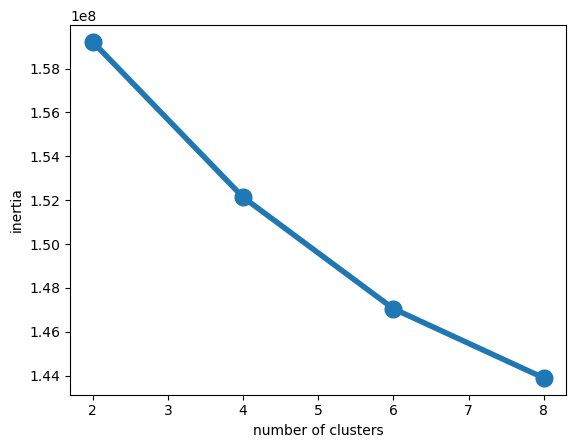

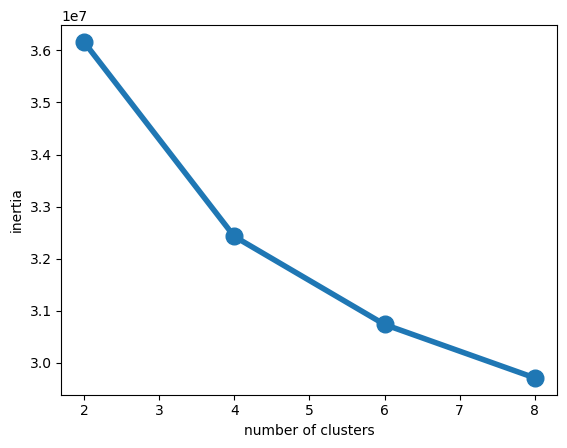

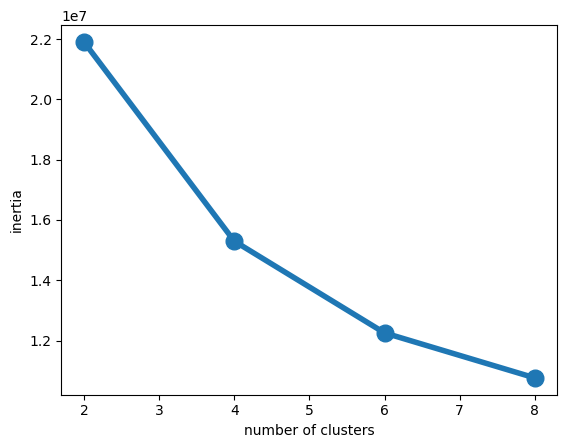

In [27]:
for idx in range(len(patches)):
    plt.plot(k_s, compactness_k_dict[idx], 'o-', linewidth=4, markersize=12);
    plt.xlabel('number of clusters')
    plt.ylabel('inertia')
    plt.show()

In [28]:
final_images_bilinear_interp = []
final_images_nn_interp = []

j = 0
for patch in patches:
    for k in k_s:
        seg_patch = ward_on_feature(
            patch, n_clusters=k, normalize=normalize,
            n_channels=n_channels_patches[j], plot=False)
        seg_full = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=bilinear_interpolation_flag)

        # Convert the original image as grayscale image to put it in the
        # background to be able to put the patch (the output of Kmeans)
        # over it in a transparent way.
        # Single channel grayscale image
        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Repeat the grayscale image along all the 3 channels
        stacked_img = np.stack((img_gray,) * 3, axis=-1)
        final_img_bilinear_interp = cv.addWeighted(
            stacked_img, weight_original_img, seg_full, weight_colored_patch,
            gamma)
        final_images_bilinear_interp.append(final_img_bilinear_interp)

        seg_full_nearest_neighbor_interp = downsample_img(
            seg_patch, full_size, full_size, False,
            interpolation_method=nn_interpolation_flag)

        nearest_neighbor_interp_final_img = cv.addWeighted(
            stacked_img, weight_original_img,
            seg_full_nearest_neighbor_interp,
            weight_colored_patch, gamma)
        final_images_nn_interp.append(nearest_neighbor_interp_final_img)
    j += 1

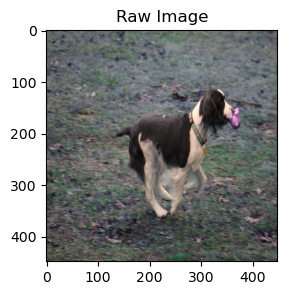

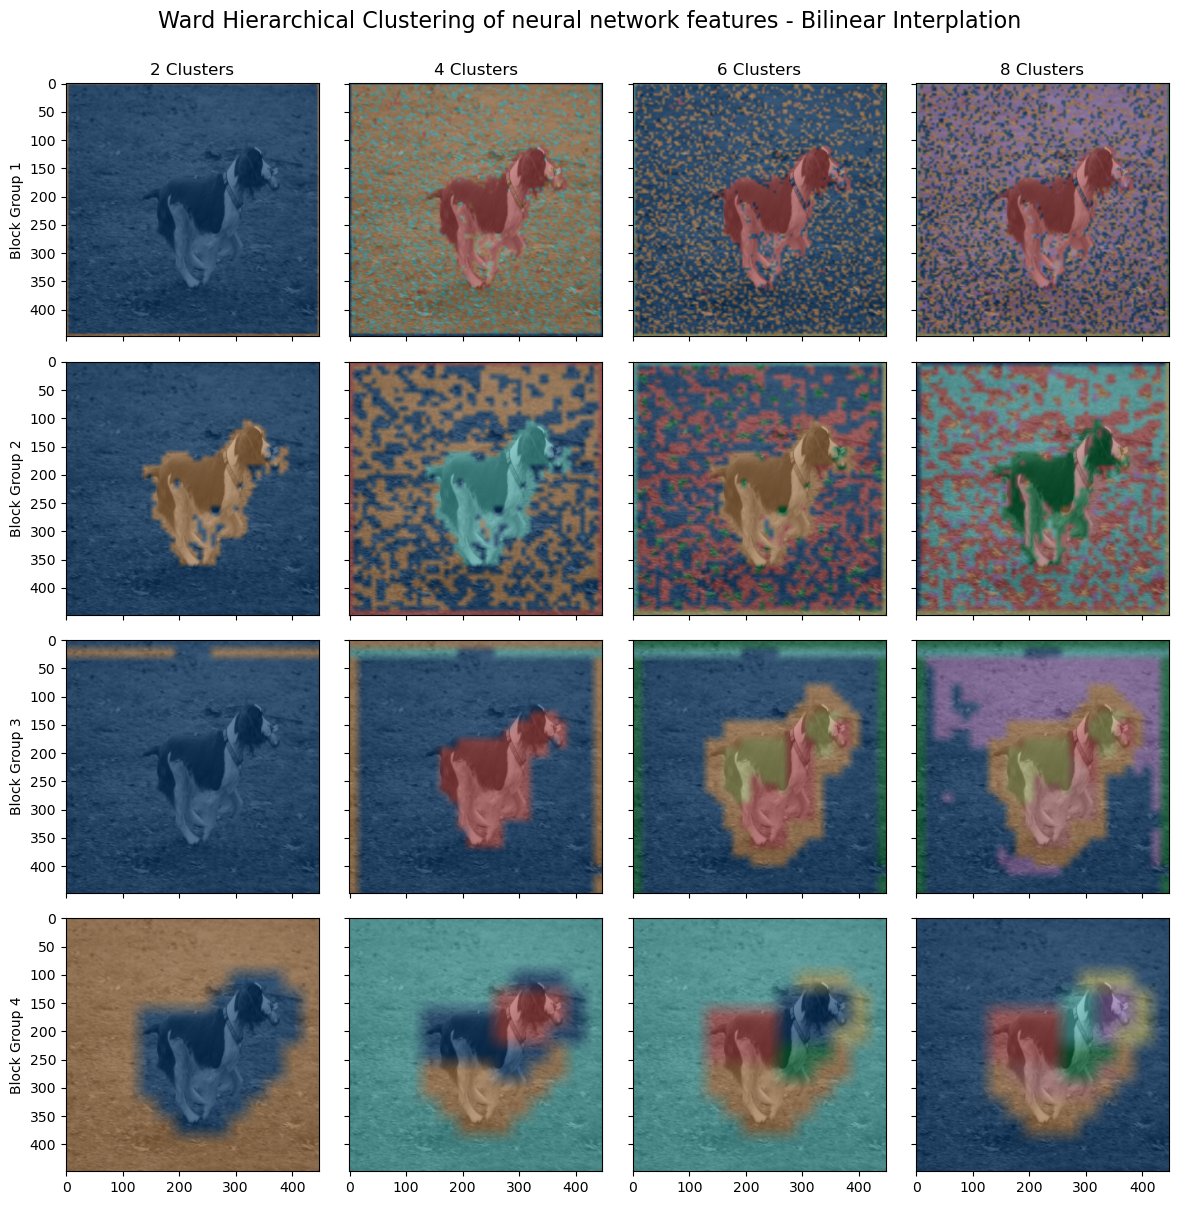

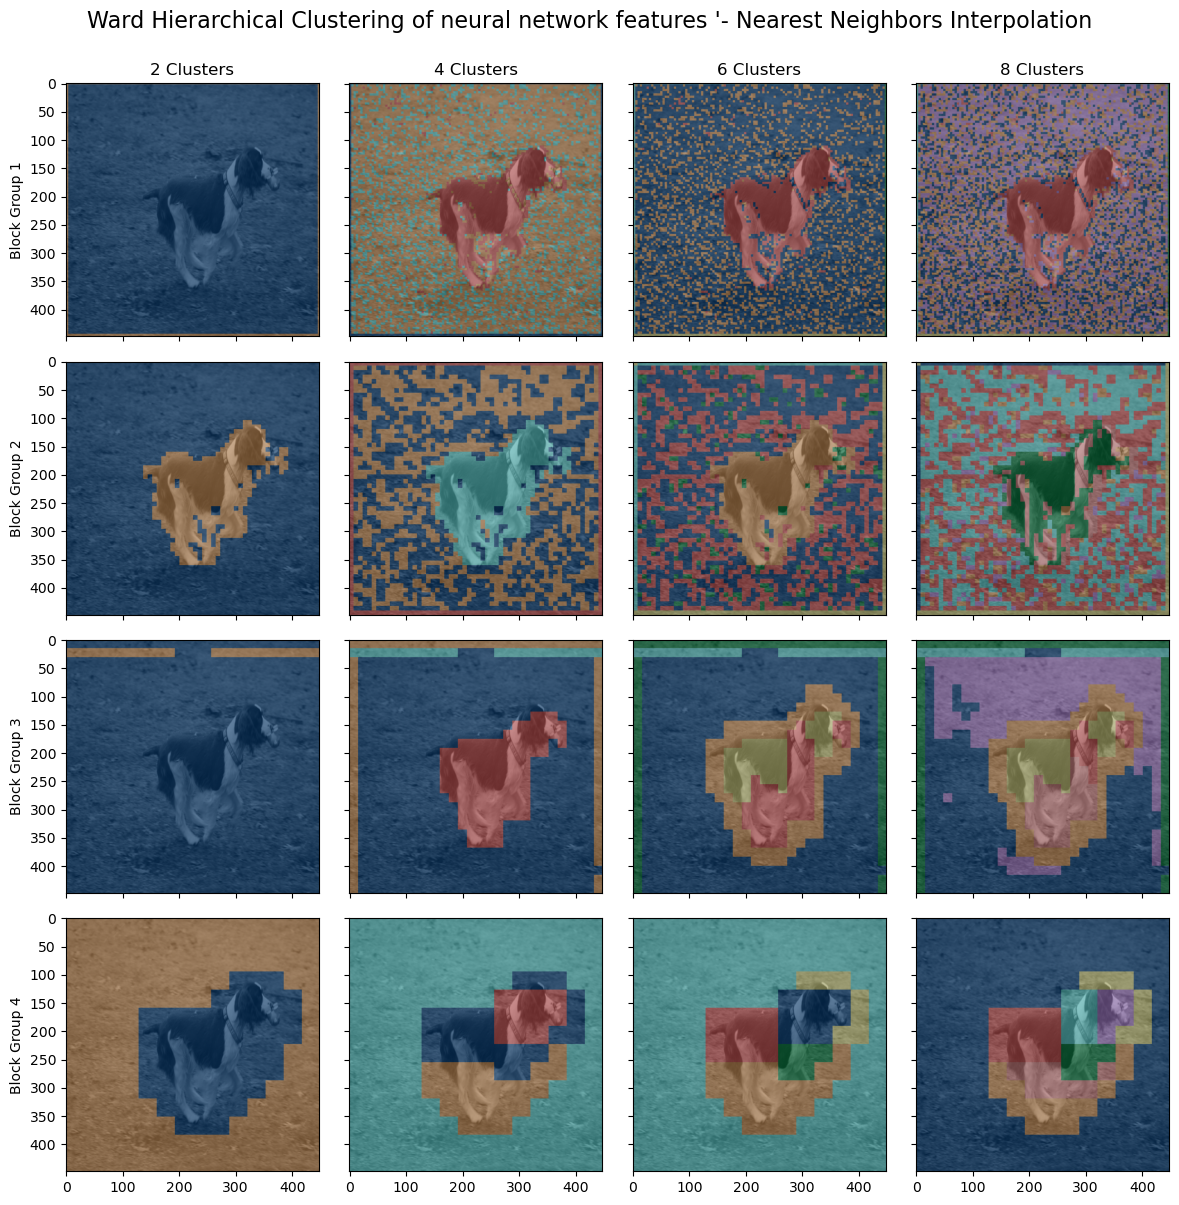

In [29]:
# Plots

# Raw Image
fig = plt.figure(figsize=(3, 3))
plt.title("Raw Image")
plt.imshow(img)
plt.show()

# Bilinear Interplation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                        figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_ward, ax in zip(final_images_bilinear_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_ward)
    i += 1
fig.suptitle(
    "Ward Hierarchical Clustering of neural network features "
    + "- Bilinear Interplation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(results_folder_rel_path + "exp1_" + type_net + "_ward_bi.pdf", dpi=100)
plt.show()

# Nearest Neighbors Interpolation
fig, axs = plt.subplots(nrows=len(patch_sizes), ncols=len(k_s),
                        figsize=(12, 12), sharex=True, sharey=True)
axs = axs.flatten()
i = 0
for img_ward, ax in zip(final_images_nn_interp, axs):
    if i % len(k_s) == 0:
        ax.set_ylabel(f"Block Group {int((i / len(k_s)) + 1)}")
    if i < len(k_s):
        ax.title.set_text(f"{k_s[i]} Clusters")
    ax.imshow(img_ward)
    i += 1
fig.suptitle(
    "Ward Hierarchical Clustering of neural network features '"
    + "- Nearest Neighbors Interpolation",
    y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(results_folder_rel_path + "exp1_" + type_net + "_ward_nni.pdf", dpi=100)
plt.show()